In [282]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

A través de este script, se realiza un scrapeo de la página web de transfermarkt para extraer información de todos los partidos de la Liga en la temporada 24/25

### **PARTE 1: ESCRAPEO**

In [283]:
#Cargamos la url de la clasificación para sacar una lista con el nombre y codigo HTML de cada equipo
url = "https://www.transfermarkt.es/laliga/startseite/wettbewerb/ES1/plus/?saison_id=2024"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}

# Realizar la petición al sitio web
response = requests.get(url, headers=headers)

# Comprobamos si hemos tenido éxito en la petición
if response.status_code == 200:
  # En caso de tener éxito le damos el contenido de la página a la librería BeautifulSoup
  soup = BeautifulSoup(response.content)
  # Lista de etiquetas td
  et_td = soup.find_all('td', class_="hauptlink no-border-links")
  #Lista vacia en la que cargamos el nombre y codigo de cada equipo
  code=[]
  # Bucamos una lista con los datos objetivo
  for etiqueta in et_td:
    url=etiqueta.find('a') #Buscamos que contega el atributo a
    url_clean=url.get("href") #Buscamos la variable href
    code.append(url_clean.split("/")[1:5:3]) #Cargamos el 2do y 3er elemento

#Condicional para ver que hay 20 equipos:
print(f"Extracción exitosa, {len(code)} claves extraidas") if len(code)==20 else "Error en la extracción"

Extracción exitosa, 20 claves extraidas


In [284]:
#Extraemos los resultados de cada equipo en un mismo diccionario

## Lista con el nombre de las claves del diccionario
lista=[]
for lis in range(len(code)):
    lista.append(code[lis][0])

## Serie con el equipo de análisis 
equipo_i=['Real Madrid', 'FC Barcelona', 'Atlético', 'Athletic Club',
          'Real Sociedad', 'Real Betis', 'Villarreal', 'Valencia CF',
          'Sevilla FC', 'Girona FC', 'RC Celta', 'UD Las Palmas', 'RCD Espanyol',
          'CA Osasuna', 'Alavés', 'Getafe CF', 'RCD Mallorca', 'Real Valladolid',
          'Rayo Vallecano', 'CD Leganés']

pd.Series([equipo_i[0]]*20)

##Diccionario con claves vacio
dfs={nombre: pd.DataFrame for nombre in lista}

## Cargamos los resultados
for eq,fil in zip(lista,range(len(code))):
    #Conexion con la web
    url=f"https://www.transfermarkt.es/{code[fil][0]}/spielplan/verein/{code[fil][1]}/saison_id/2024/plus/1#ES1"
    response=requests.get(url, headers=headers)
    #Seleccionamos la tabla del html con los resultados
    data=pd.read_html(response.content)[2]
    #Definimos el equipo objetivo 
    equipo=pd.DataFrame([equipo_i[fil]]*len(data), columns=["equipo_i"])
    #Añadimos concatenación al diccionario
    dfs[eq]=pd.concat([data, equipo], axis=1)

### **PARTE 2: MANIPULACIÓN DE DATOS**

In [285]:
#FECHA PARA CADA DF

for eq in lista:
    # Eliminamos el nombre del dia de la fecha con expresión regular
    ## .str: acceso a los strings
    ## .replace: reemplaza un patron regular dentro de un eq
    ## Patron regular: r'^\w{3}\s+': ^(texto empieza por patron), \{w}3 (3 caracteres), \s (uno o más espacios)
    ## Por: "" (Elemento vacio)
    ## regex=True (Primer parámetro es una expresión regular)
    dfs[eq]["fecha"]=dfs[eq]["Fecha"].str.replace(r"^\w{3}\s+", "", regex=True)

    # Pasamos la columna a datetime
    dfs[eq]["fecha"]=pd.to_datetime(dfs[eq]["fecha"], format="%d/%m/%Y")
    ## Organizamos el df por partidos de forma descendente
    dfs[eq]=dfs[eq].sort_values(by="fecha")

    # Creamos variable de días de descanso
    dfs[eq]["desc_i"]=dfs[eq]["fecha"].diff(1)
    ## Nos quedamos con los valores de numero de dias
    dfs[eq]["desc_i"]=dfs[eq]["desc_i"].dt.days

    #Eliminamos columna de fecha
    dfs[eq]=dfs[eq].drop(columns=["Fecha", "Horario"])

In [286]:
#EQUIPOS PARA CADA DF

for eq in lista:
    #Eliminamos la clasificacion del nombre
    ## \s espacio antes de la clasificacion
    ## \( empieza parentesis
    ## \(d+) uno o más numeros
    ## \. punto 
    ## \) cierra parétesis
    dfs[eq]["Local"]=dfs[eq]["Local.1"].str.replace(r"\s\((\d+)\.\)", "", regex=True)
    dfs[eq]["Visitante"]=dfs[eq]["Visitante.1"].str.replace(r"\s\((\d+)\.\)", "", regex=True)

    #Dummy si el equipo de analisis (equipo_i) es local
    ## La condicione genera un booleano con al pasarlo a int es una dummy
    dfs[eq]["local_i"]=(dfs[eq]["Local"]==dfs[eq]["equipo_i"]).astype(int)

    #Equipo rival
    dfs[eq]["rival_j"]=None
    dfs[eq].loc[dfs[eq]["Local"]!=dfs[eq]["equipo_i"],["rival_j"]]=dfs[eq]["Local"]
    dfs[eq].loc[dfs[eq]["Visitante"]!=dfs[eq]["equipo_i"],["rival_j"]]=dfs[eq]["Visitante"]


    #Posiciones
    ## Equipo local
    dfs[eq]["pos_local"]=dfs[eq]["Local.1"].str.extract(r"\((\d+)\.\)")
    ## Equipo visitante
    dfs[eq]["pos_visitante"]=dfs[eq]["Visitante.1"].str.extract(r"\((\d+)\.\)")

    ## Equipo_i
    dfs[eq]["pos_i"]=None
    ##Extraemos la posicion cuando el equipo es local
    dfs[eq].loc[dfs[eq]["local_i"]==1,"pos_i"]= dfs[eq]["pos_local"]
    ##Extraemos la posicion cuando el equipo es visitante
    dfs[eq].loc[dfs[eq]["local_i"]==0,"pos_i"]= dfs[eq]["pos_visitante"]

    ## Rival_j
    dfs[eq]["pos_j"]=None
    ##Extraemos la posicion cuando el equipo es local
    dfs[eq].loc[dfs[eq]["local_i"]==0,"pos_j"]= dfs[eq]["pos_local"]
    ##Extraemos la posicion cuando el equipo es visitante
    dfs[eq].loc[dfs[eq]["local_i"]==1,"pos_j"]= dfs[eq]["pos_visitante"]

    #Eliminamos columnas utilizadas
    dfs[eq]=dfs[eq].drop(columns=["Local", "Local.1", "Visitante", "Visitante.1", "pos_local", "pos_visitante"])

In [287]:
#GOLES PARA CADA DF

for eq in lista:
    #Extraccion de resultados
    ## (\d): digito antes de : --> goles del equipo local
    ## :(\d) digito despues de : --> goles del equipo visitante
    dfs[eq][["gol_local", "gol_visitante"]]=dfs[eq]["Resultado"].str.extract(r"(\d):(\d)")

    #Goles de equipo_i
    dfs[eq]["gol_i"]=None
    #Extraemos los goles cuando el equipo es local
    dfs[eq].loc[dfs[eq]["local_i"]==1, "gol_i"]=dfs[eq]["gol_local"]
    #Extraemos los goles cuando el equipo es visitante
    dfs[eq].loc[dfs[eq]["local_i"]==0, "gol_i"]=dfs[eq]["gol_visitante"]

    #Goles de rival_j
    dfs[eq]["gol_j"]=None
    #Extraemos los goles cuando el equipo es local
    dfs[eq].loc[dfs[eq]["local_i"]==0, "gol_j"]=dfs[eq]["gol_local"]
    #Extraemos los goles cuando el equipo es visitante
    dfs[eq].loc[dfs[eq]["local_i"]==1, "gol_j"]=dfs[eq]["gol_visitante"]

    #Media Movil de goles de orden 5 
    #Shift: introducimos un retado
    #Rolling: crea una ventana movil de window periodos y min_periods para las primeras observaciones
    dfs[eq]["MA(5)_gol_i"]=dfs[eq]["gol_i"].rolling(window=5, min_periods=1).mean()

    #Eliminamos columnas utilizadas
    dfs[eq]=dfs[eq].drop(columns=["Resultado", "gol_local", "gol_visitante"])

In [288]:
# RESULTADO PARA CADA DF

for eq in lista:
    #Dummy victoria_i
    ## Al compara las columnas, obtenemos un boleano que cuando lo pasamos a int nos da la dummy que queremos
    dfs[eq]["vic_i"] = (dfs[eq]["gol_i"] > dfs[eq]["gol_j"]).astype(int)
    #Dummt empate_i
    dfs[eq]["emp_i"] = (dfs[eq]["gol_i"] == dfs[eq]["gol_j"]).astype(int)
    #Dummy derrota_i
    dfs[eq]["derr_i"] = (dfs[eq]["gol_i"] < dfs[eq]["gol_j"]).astype(int)

    #Categorica puntos
    dfs[eq]["puntos_i"]=None
    dfs[eq].loc[dfs[eq]["vic_i"]==1,"puntos_i"]=3
    dfs[eq].loc[dfs[eq]["emp_i"]==1,"puntos_i"]=1
    dfs[eq].loc[dfs[eq]["derr_i"]==1,"puntos_i"]=0

    ## Media móvil de puntos de orden 5
    dfs[eq]["MA(5)_puntos_i"]=dfs[eq]["puntos_i"].rolling(window=5, min_periods=1).mean()

In [289]:
#RESTO DE VARIABLES PARA CADA DF

for eq in lista:
    # Sistema de juego como categorica
    dfs[eq]["formacion_i"]=dfs[eq]["Sistema de juego"].astype("category")

    #Categorica numero de entrenadores
    dfs[eq]["entr_i"]=dfs[eq]["Entrenadores"].astype("category")

    # Renombramos variables
    dfs[eq]=dfs[eq].rename(columns={"Jornada": "jornada", "Espectadores": "espectadores"})

    # Eliminamos columnas utilizadas
    dfs[eq]=dfs[eq].drop(columns=["Sistema de juego","Entrenadores"])

### **PARTE 3: VISUALIZACIÓN DE DATOS**

##### A) Media Movil de Goles: diferencia entre Madrid y Betis

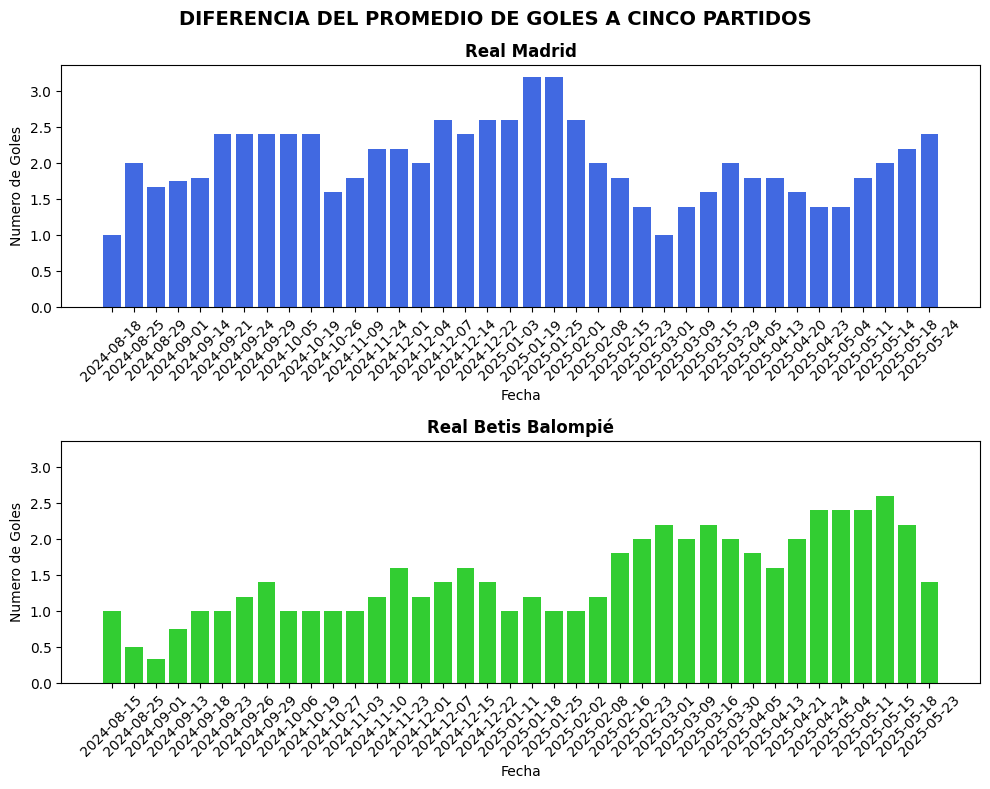

In [290]:
#Creamos figuras y ejes
fig,ax=plt.subplots(2,1, figsize=(10, 8), sharey=True)

# Real Madrid
ax[0].bar(dfs["real-madrid"]["fecha"].astype(str), dfs["real-madrid"]["MA(5)_gol_i"], color="royalblue")
ax[0].set_title("Real Madrid", fontweight="bold")
ax[0].set_xlabel("Fecha")
ax[0].set_ylabel("Numero de Goles")
ax[0].tick_params(axis='x', labelrotation=45)

#Estadio de la Cerámica
ax[1].bar(dfs["real-betis-sevilla"]["fecha"].astype(str), dfs["real-betis-sevilla"]["MA(5)_gol_i"], color="limegreen")
ax[1].set_title("Real Betis Balompié", fontweight="bold")
ax[1].set_xlabel("Fecha")
ax[1].set_ylabel("Numero de Goles")
ax[1].tick_params(axis='x', labelrotation=45)

#Configuración final del gráfico
fig.suptitle("diferencia del promedio de goles a cinco partidos".upper(), fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

##### B) Media Movil de Puntos: diferencia entre Madrid y Betis

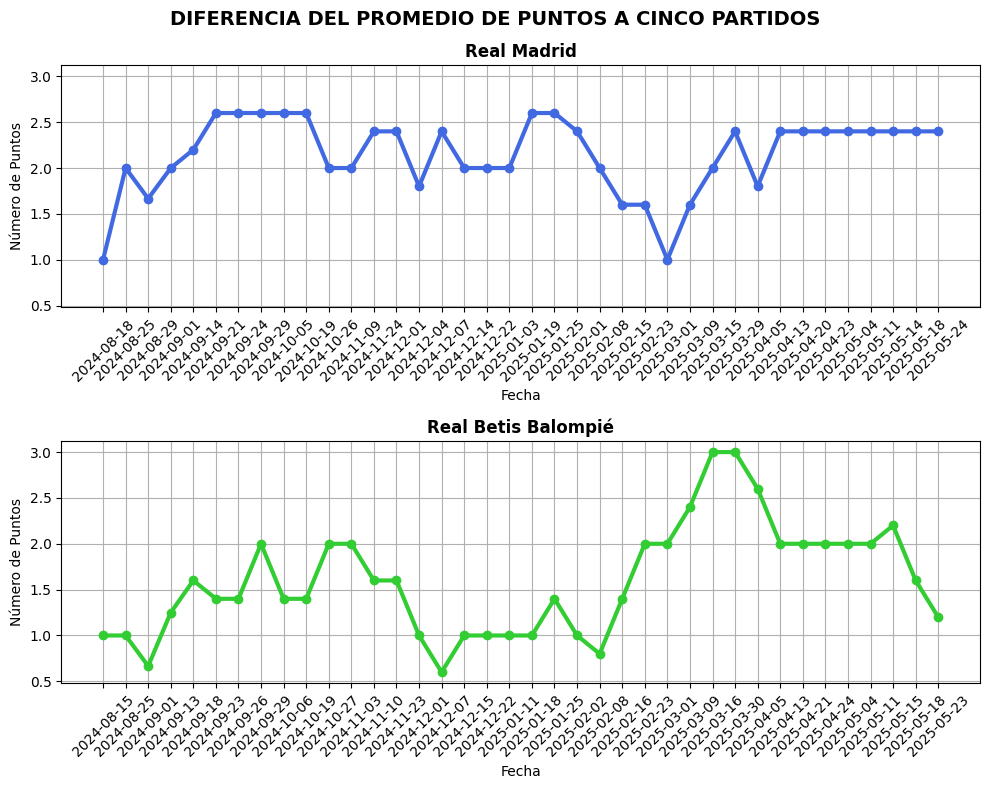

In [291]:
#Creamos figuras y ejes
fig,ax=plt.subplots(2,1, figsize=(10, 8), sharey=True)

# Real Madrid
ax[0].plot(dfs["real-madrid"]["fecha"].astype(str), dfs["real-madrid"]["MA(5)_puntos_i"], color="royalblue", linewidth=3, marker="o")
ax[0].set_title("Real Madrid", fontweight="bold")
ax[0].set_xlabel("Fecha")
ax[0].set_ylabel("Número de Puntos")
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].grid()

#Estadio de la Cerámica
ax[1].plot(dfs["real-betis-sevilla"]["fecha"].astype(str), dfs["real-betis-sevilla"]["MA(5)_puntos_i"], color="limegreen", linewidth=3, marker="o")
ax[1].set_title("Real Betis Balompié", fontweight="bold")
ax[1].set_xlabel("Fecha")
ax[1].set_ylabel("Número de Puntos")
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].grid()

#Configuración final del gráfico
fig.suptitle("diferencia del promedio de puntos a cinco partidos".upper(), fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

##### C) Clasificación Final: Grafico de barra horiontal

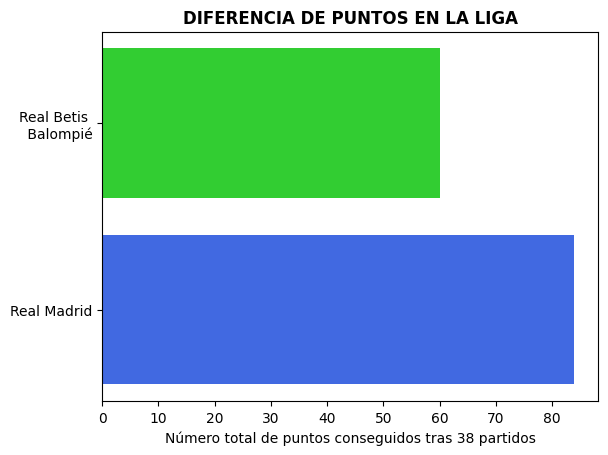

In [292]:
#Clasificcación de cada equipo
eq=["Real Madrid", "Real Betis \n Balompié"]
clas=[sum(dfs["real-madrid"]["puntos_i"]), sum(dfs["real-betis-sevilla"]["puntos_i"])]

plt.barh(eq, clas, color=["royalblue", "limegreen"]) #plt.barh(etiquetas, valores, color)
plt.title("Diferencia de puntos en la liga".upper(), fontweight="bold")
plt.xlabel("Número total de puntos conseguidos tras 38 partidos")
#plt.xlim(, 1)
plt.show()

### **PARTE 4: EXPORTAMOS A SQLITE**

In [ ]:
#Nos conectamos con la base de datos o la creamos
conexion=sqlite3.connect("clasificacion_liga_2425.db")

#Cargamos cada dfs a través de un bucle cn items(clave, valor)
for nombre, tabla in dfs.items():
    tabla.to_sql(nombre, con=conexion, if_exists='replace')

#Cerramos la conexion
conexion.close()
